In [ ]:
# Import Keras with tensorflow backend
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
#from keras_applications import vgg16
from keras.applications import vgg16

# Import OpenCV
import cv2

# Utility
import os
import numpy as np
import itertools
import random
from collections import Counter
from glob import iglob

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

# Confusion Matrix & classification report
from sklearn.metrics import confusion_matrix, classification_report

# Plot
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set dataset folder path
BASE_DATASET_FOLDER = os.path.join("/content/drive/MyDrive/dataset")
TRAIN_FOLDER = "train"
VALIDATION_FOLDER = "validation"
TEST_FOLDER = "test"

# VGG image size
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

# Keras settings
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 0.0001
MODEL_PATH = os.path.join("derma_diseases_detection.h5")

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TRAIN_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=TRAIN_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=True)

Found 938 images belonging to 3 classes.


In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, VALIDATION_FOLDER),
        target_size=IMAGE_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 97 images belonging to 3 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=VAL_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 368 images belonging to 3 classes.


In [ ]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratosis'}


In [ ]:
vgg_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

### Create model

In [ ]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

In [ ]:
# Compile the model

from tensorflow.keras import models,optimizers,layers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

In [ ]:

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=val_generator.samples//val_generator.batch_size)

Epoch 1/50
 2/14 [===>..........................] - ETA: 42s - loss: 1.3678 - acc: 0.3774 

In [ ]:
model.save("/content/drive/MyDrive/derma_diseases_detection.h5")

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:

loss, accuracy = model.evaluate_generator(test_generator,steps=test_generator.samples//test_generator.batch_size)

In [ ]:
print("Accuracy: %f\nLoss: %f" % (accuracy,loss))

In [ ]:

Y_pred = model.predict_generator(test_generator,verbose=1, steps=test_generator.samples//test_generator.batch_size)

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

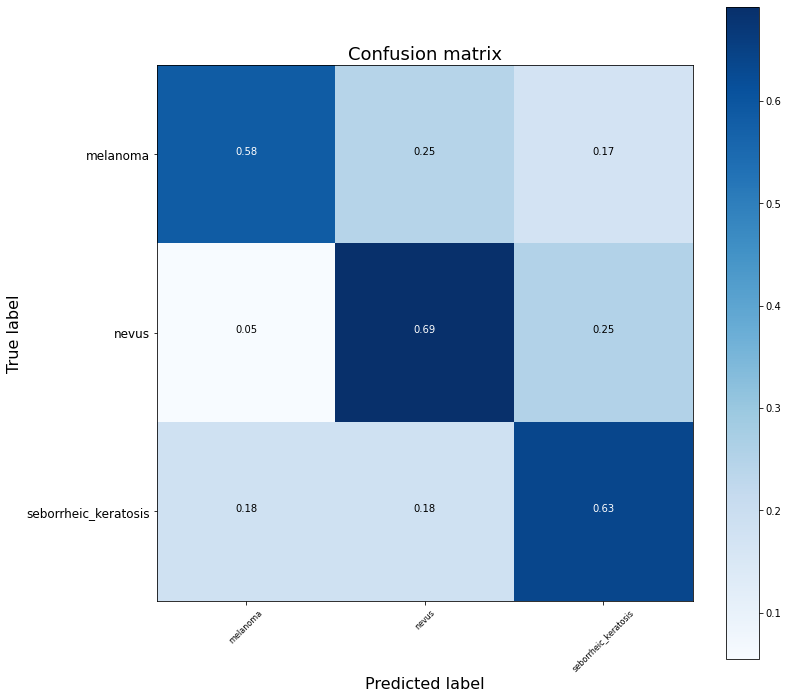

In [ ]:
plot_confusion_matrix(cnf_matrix, list(classes.values()))

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=list(classes.values())))

                      precision    recall  f1-score   support

            melanoma       0.72      0.58      0.64       118
               nevus       0.68      0.69      0.68       146
seborrheic_keratosis       0.54      0.63      0.58       104

            accuracy                           0.64       368
           macro avg       0.64      0.64      0.64       368
        weighted avg       0.65      0.64      0.64       368



In [ ]:
def load_image(filename):
    img = cv2.imread(os.path.join(BASE_DATASET_FOLDER, TEST_FOLDER, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: melanoma, file: melanoma/ISIC_0013672.jpg
PREDICTED: class: nevus, confidence: 0.519415


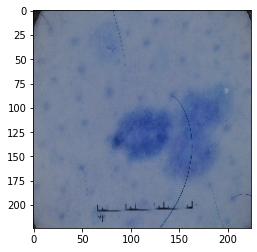

<Figure size 432x288 with 0 Axes>

SOURCE: class: seborrheic_keratosis, file: seborrheic_keratosis/ISIC_0014597.jpg
PREDICTED: class: nevus, confidence: 0.617316


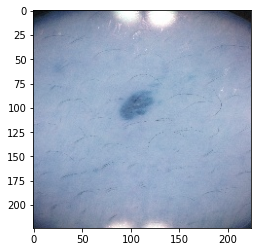

SOURCE: class: nevus, file: nevus/ISIC_0013226.jpg
PREDICTED: class: nevus, confidence: 0.601448


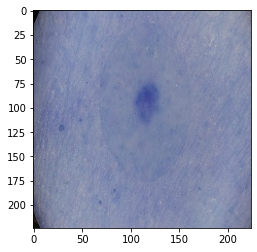

<Figure size 432x288 with 0 Axes>

SOURCE: class: nevus, file: nevus/ISIC_0013809.jpg
PREDICTED: class: nevus, confidence: 0.613157


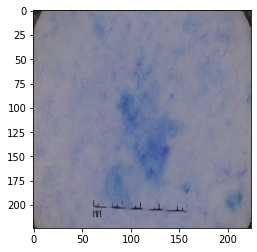

<Figure size 432x288 with 0 Axes>

SOURCE: class: nevus, file: nevus/ISIC_0012741.jpg
PREDICTED: class: nevus, confidence: 0.696138


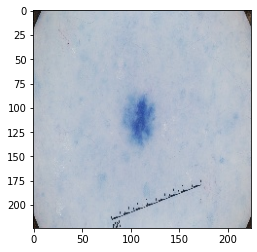

<Figure size 432x288 with 0 Axes>

SOURCE: class: seborrheic_keratosis, file: seborrheic_keratosis/ISIC_0014526.jpg
PREDICTED: class: nevus, confidence: 0.625266


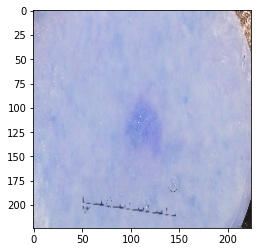

<Figure size 432x288 with 0 Axes>

SOURCE: class: nevus, file: nevus/ISIC_0012521.jpg
PREDICTED: class: nevus, confidence: 0.578055


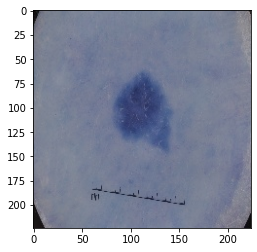

<Figure size 432x288 with 0 Axes>

SOURCE: class: seborrheic_keratosis, file: seborrheic_keratosis/ISIC_0013054.jpg
PREDICTED: class: nevus, confidence: 0.748508


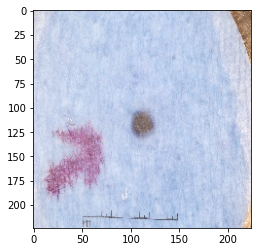

<Figure size 432x288 with 0 Axes>

SOURCE: class: nevus, file: nevus/ISIC_0012526.jpg
PREDICTED: class: nevus, confidence: 0.631543


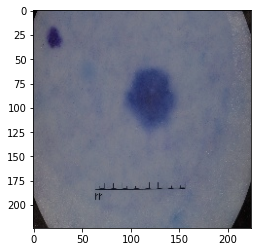

<Figure size 432x288 with 0 Axes>

SOURCE: class: melanoma, file: melanoma/ISIC_0014076.jpg
PREDICTED: class: nevus, confidence: 0.561329


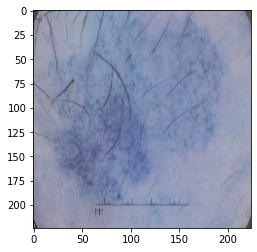

<Figure size 432x288 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(test_generator.filenames, 10)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()